# Boston Housing dataset - an intro to regression  
In this project we will look at a regression analysis of the Boston housing prices. This dataset was collected in 1978 and it contains information about 506 homes in Boston, Massachusetts. Our main goal is to create a machine learning model that will predict the house price as a function of ther input variables, of which there are 13 (+ 1 output variable): 

CRIM - per capita crime rate by town

ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS - proportion of non-retail business acres per town.

CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

NOX - nitric oxides concentration (parts per 10 million)

RM - average number of rooms per dwelling

AGE - proportion of owner-occupied units built prior to 1940

DIS - weighted distances to five Boston employment centres

RAD - index of accessibility to radial highways

TAX - full-value property-tax rate per 10,000USD 

PTRATIO - pupil-teacher ratio by town
B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT - % lower status of the population
MEDV - Median value of owner-occupied homes in thousands (USD) = our output variable

Since the output variable is continuous, we're dealing with regression instead of classification. Our aim is to predict the house price as precisely as possible, while penalizing the model based on how inaccurate our predictions were. For this task we'll look at the classic linear regression, its use as a predictor and a tool of statistical inference, its consequent problems and how we may alleviate some of them by imposing L2/L1 regularizations on our regressor coefficients. We will also try to create a feedforward neural network model and see how it compares on such a simple datset against its less complex competitors.

In [104]:
# Import some important libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

In [105]:
# Import the dataset 
col_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'] # column names, taken from Kaggle
boston = pd.read_csv('housing.csv', header = None, names = col_names, sep = r'\s+') # regex separator = 'one or more whitespace characters'

The first few rows of our dataset look like this:

In [106]:
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## Exploratory Data Analysis 
Firstly, let's explore our data a bit. We see that all of our predictor variables are numerical, and most of them (11) are continuous (mostly proportions/ratios/rates, but also weighted distances, concentrations, per capita statistics). We only have 2 categorical variables, which are *CHAS*, a dummy (binray) variable indicating whether the region is located along the Charles river or not and *RAD*, which is the accesibility index to radial highways. 
Before drawing any graphs, let's check how many of our values are missing. 

In [107]:
boston.isna().sum(axis = 0)

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Our dataset looks wonderful, since none of the values are missing, which will save us from the woes of imputation and deletion of some observations. 
Some summary statistics of our variables: 

In [108]:
num_vars = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
cat_vars = ['CHAS', 'RAD']
boston[num_vars].describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.900000,37.970000,50.000000


In [109]:
# Number of observations by category in cat. varaibles:
for i in cat_vars:
    print('---{}---'.format(i))
    print(boston[i].value_counts())

---CHAS---
0    471
1     35
Name: CHAS, dtype: int64
---RAD---
24    132
5     115
4     110
3      38
6      26
2      24
8      24
1      20
7      17
Name: RAD, dtype: int64


It seems that some of the empirical quantiles indicate skew in some of our variables. We can confirm this by looking at the histograms (and/or KDE's) of our continuous variables. Moreover, we see that the *RAD* categorical variable has a lot of levels (9 to be exact), ranging from 1 to 24. It's questionable whether we would benefit from considering it as a continuous variable; we can certainly try this, as it is an index and therefore an ordinal variable. 
We will also delete those rows, whose output variable was >= 50.0, since metadata contained the information that prices higher than this value are censored (and therefore cut at 50.0). 

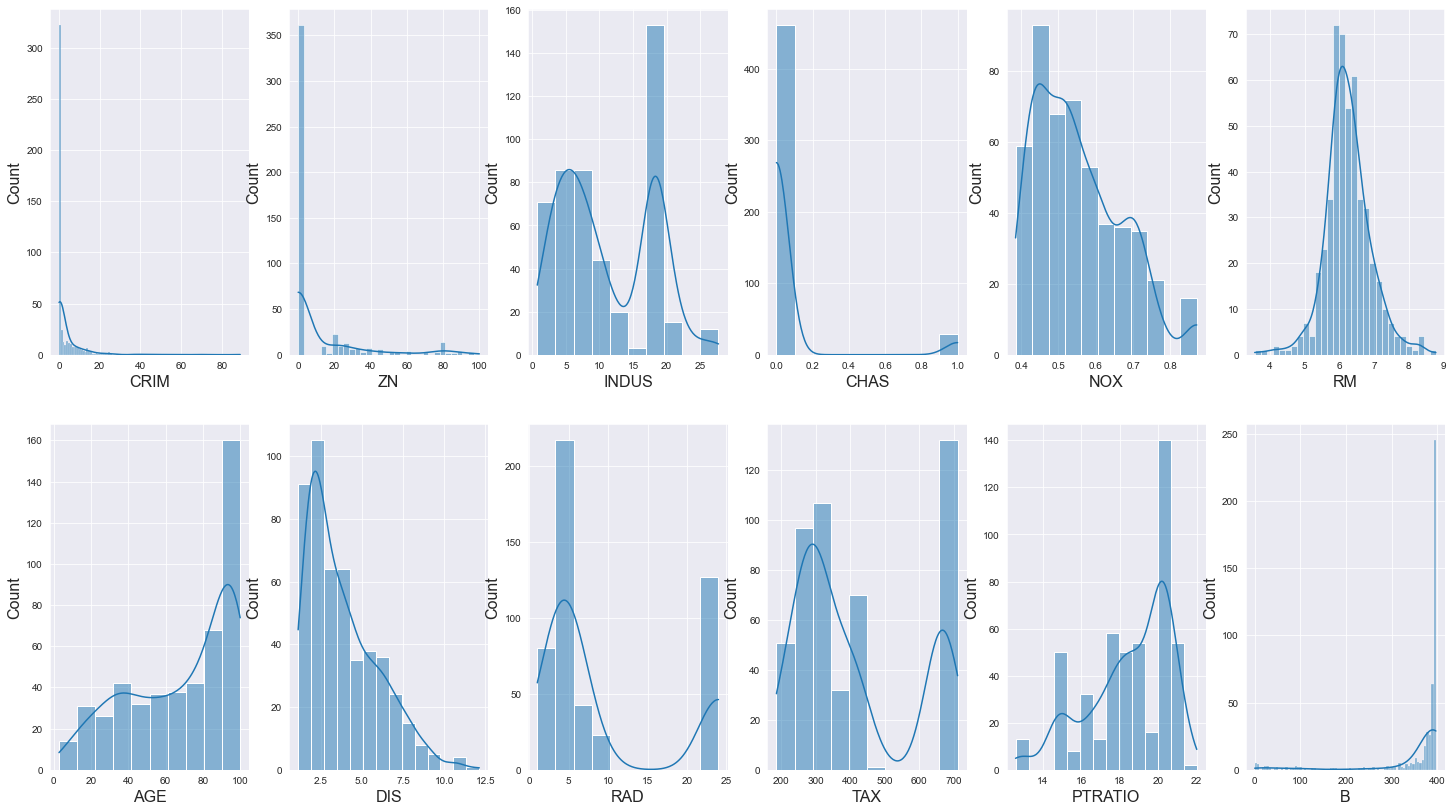

In [110]:
boston = boston.loc[boston['MEDV'] < 50.0] # delete rows with MEDV >= 50
# Import seaborn module and draw histograms
import seaborn as sns 
sns.set_style('darkgrid')
fig, axs = plt.subplots(nrows = 2, ncols = 6, figsize = (25, 14))
axs = axs.flatten()
for i in range(12):
    sns.histplot(data = boston, x = col_names[i], ax = axs[i], kde = True)

Although most of these variables don't seem to follow the normal distribution, it's not a cause for concern unless we're dealing with outliers or heavily skewed variables. We can try to fix the skew by using a log-transform, as a part of our preprocessing process. Now let us check for outliers, or more precisely, how many outliers are there in the individual columns. We will use the Z-score method with a threshold of 3: 

In [111]:
# Import the stats module 
from scipy import stats
boston_z = np.abs(stats.zscore(boston))

# Percentage of observations considered as outliers in our regressors 
round(((boston_z > 3).sum() / boston.count()) * 100, 2)

CRIM       1.63
ZN         5.31
INDUS      0.00
CHAS       5.92
NOX        0.00
RM         2.04
AGE        0.00
DIS        1.02
RAD        0.00
TAX        0.00
PTRATIO    0.00
B          4.90
LSTAT      1.02
MEDV       1.22
dtype: float64

This table shows us the percentage of observations considered as outliers in our data. The worst columns are the dummy varaible *CHAS*, where every value '1' was considered as an outlier because of how imbalanced the variable is; this should, however, not be a problem. The other problematic variables were *ZN* and *B*; if we choose to include them in our linear model, we should either do an analysis of Cook distances to determine whether these outliers are influential, or simply omit these outliers. Now we can look at the correlation matrix (or Spearman/Kendall coefficients with categorical variables) to see beforehand which of our predictors seem to have an impact on the median house prices. 

<AxesSubplot:>

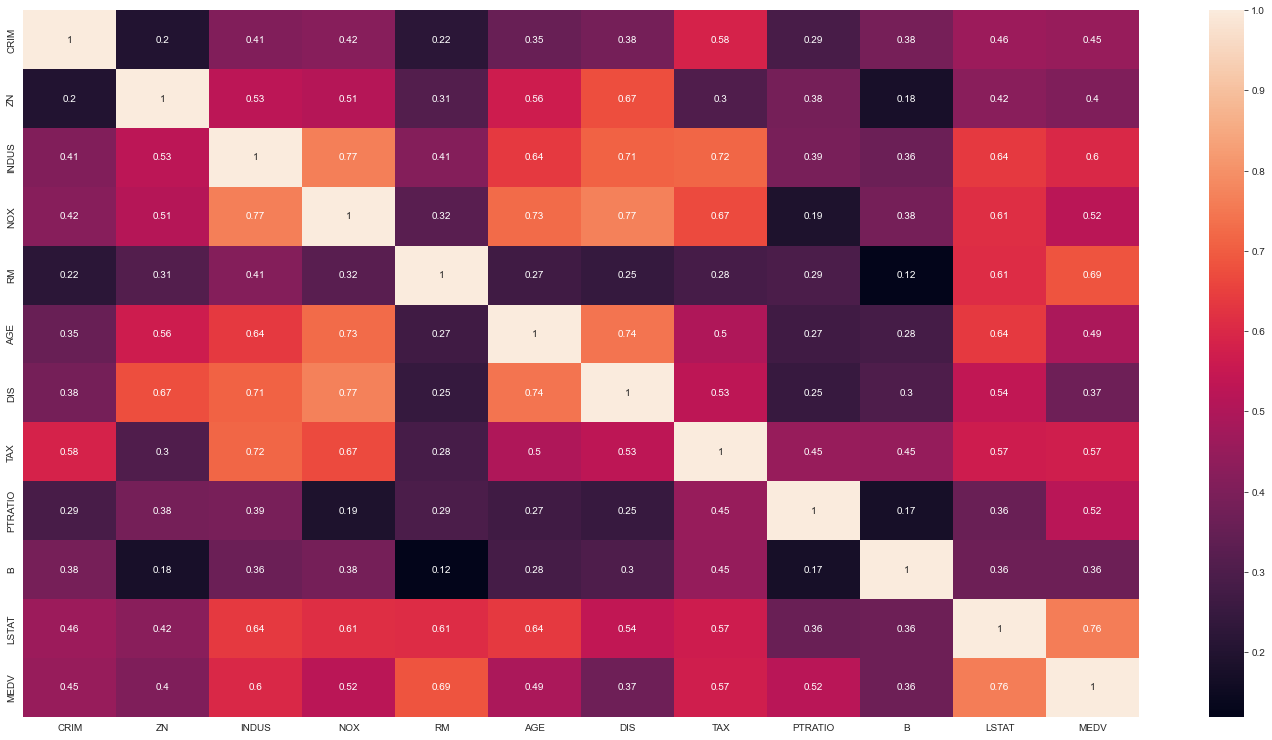

In [112]:
plt.figure(figsize = (25, 13))
sns.heatmap(boston[num_vars].corr().abs(), annot = True)

It looks like a lot of the regressors show correlation with each other. and most are even correlated with our output variable *MEDV* (weak to medium correlation si shown with the varaibales *B*, 0.36 and *DIS*, 0.37; medium to strong correlation is shown with variables *RM*, 0.69 and 'LSTAT', 0.76). We shouldn't ignore the correlations between the predictors, as the results of linear regression (namely the standard error estimations) will be skewed and misleading - hence the use of a regularization method will be in order. 
Let's check the kendall/spearman coefficent between our output variable and the categorical/ordinal *CHAS* and *RAD* variables (kendall for *CHAS* beacuse of the low number of levels, spearman for *RAD* - [Khamis, 2008]): 

In [113]:
print(stats.kendalltau(boston['MEDV'], boston['CHAS'])) # None to very weak correlation 
print(stats.spearmanr(boston['MEDV'], boston['RAD'])) # weak-to-mid negative correlation

KendalltauResult(correlation=0.07006215433652462, pvalue=0.058544766135123)
SpearmanrResult(correlation=-0.3785018909700959, pvalue=3.881528463564051e-18)


The results of rank correlation tell us, that we may omit the *CHAS* variable and retain the *RAD* variable. Let's move on to preprocessing, which means practically just log-transforming and scaling our skewed variables at this point: 
## Data Preprocessing
Let's start by looking at the empirical skewness of our variables and transform those, which surpass a given skewness threshold. Let's set the threshold to 0.5:  

In [114]:
for i in num_vars:
    print("{} has a skew of {}.".format(i, round(boston[i].skew(), 2)))

CRIM has a skew of 5.16.
ZN has a skew of 2.24.
INDUS has a skew of 0.32.
NOX has a skew of 0.75.
RM has a skew of 0.17.
AGE has a skew of -0.59.
DIS has a skew of 1.0.
TAX has a skew of 0.68.
PTRATIO has a skew of -0.82.
B has a skew of -2.83.
LSTAT has a skew of 0.91.
MEDV has a skew of 0.78.


It seems that most of the variables are moderately skewed and the only ones that will go untransformed are *INDUS* and *RM*. 

In [115]:
# Create an empty DataFrame
X = pd.DataFrame()

# Check skewness for each varaible and transform if needed
for i in num_vars:
    if abs(boston[i].skew()) > 0.5: 
        X = pd.concat([X, np.log1p(boston[i])], axis = 1)
    else: X = pd.concat([X, boston[i]], axis = 1)

# Add the logged ordinal variable 'RAD' as well
X = pd.concat([X, np.log1p(boston['RAD'])], axis = 1)

We may create a new *y* vector that will contain our output variable, leaving the X as our design matrix. The scaling transformations will be carried out inside our model pipeline as a part of the modelling process. 

In [116]:
y = X['MEDV']
X = X.drop(columns = ['MEDV'])

At this moment, we have to think about the inclusion of variables with a significant portion of outliers (~ 5% of observations) in our linear models. Let's look at the simple regression graph of these problematic variables *B* and *ZN*: 

<AxesSubplot:xlabel='B', ylabel='MEDV'>

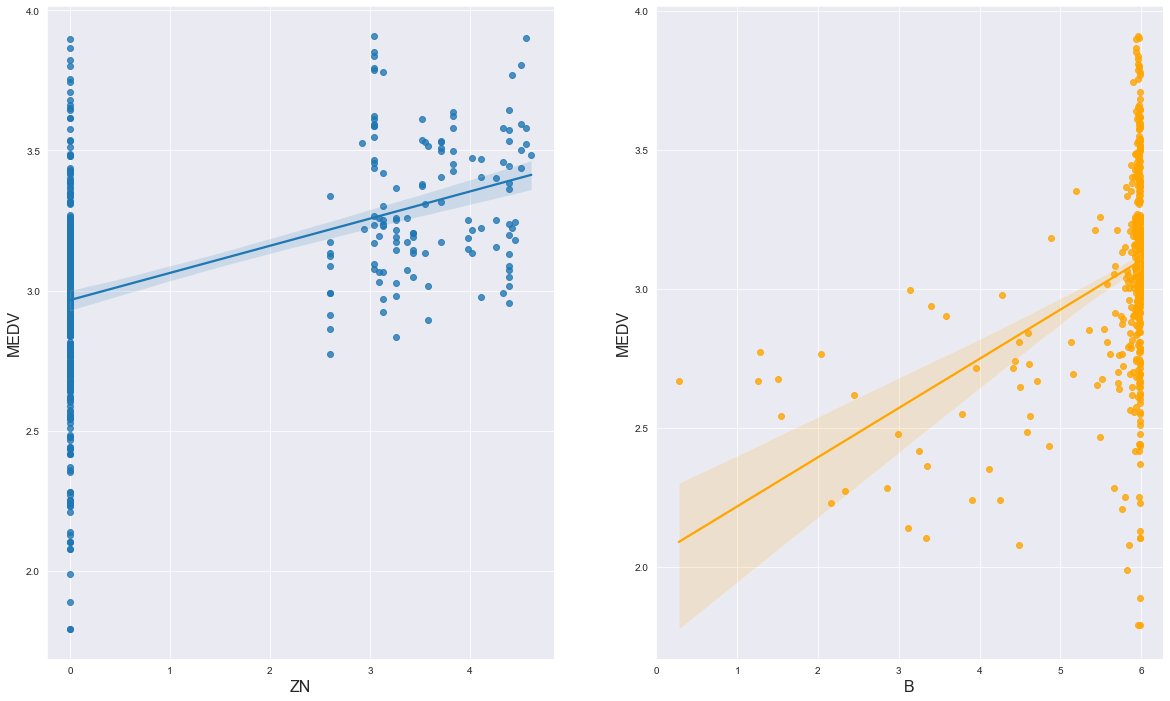

In [117]:
fig, axs = plt.subplots(figsize = (20, 12), ncols = 2)
sns.regplot(x = X['ZN'], y = y, ax = axs[0])
sns.regplot(x = X['B'], y = y, ax = axs[1], color = 'orange')

For now, we'll leave all the observations in our data; hopefully, the log transform we used will also help diminish the effect of the outlier observations. Let's move on to our first model, linear regression

## Linear Regression (and a bit of inference)
Let's build and inspect a basic linear regression model (OLS): 

In [118]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Create and train the model 
pipe = Pipeline([('scal', StandardScaler()), ('reg', LinearRegression())])
pipe.fit(X, y)
print('R2 on the training set is {}.'.format(round(pipe.score(X, y), 3)))

# Our coefficients 
cfs = dict(zip(X.columns, np.around(pipe['reg'].coef_, 5)))
cfs['intercept'] = np.around(pipe['reg'].intercept_, 5)
for key, value in cfs.items():
    print(key, ' : ', value)

R2 on the training set is 0.797.
CRIM  :  -0.15254
ZN  :  -0.00941
INDUS  :  0.01036
NOX  :  -0.05583
RM  :  0.05001
AGE  :  0.00785
DIS  :  -0.06947
TAX  :  -0.06511
PTRATIO  :  -0.07117
B  :  0.02776
LSTAT  :  -0.18439
RAD  :  0.1279
intercept  :  3.0578


One of the reasons linear regression is so popular is the easy* interpretation of what the individual coefficients mean, coupled with easily calculable estimated standard errors (and therefore confidence intervals). This interpretation is made a bit tougher by the log-transformations and scaling, but it's still fairly simple to do so. A great guide about how to deal with these transformations can be seen [here.](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqhow-do-i-interpret-a-regression-model-when-some-variables-are-log-transformed/) 
However, before trusting our inference results we need to make sure that our model meets the assumptions of a proper linear model; mainly that the residuals are identically normally distributed with a zero mean. Let us have a look at this:

Text(0.5, 1.0, 'Scatterplot of residuals')

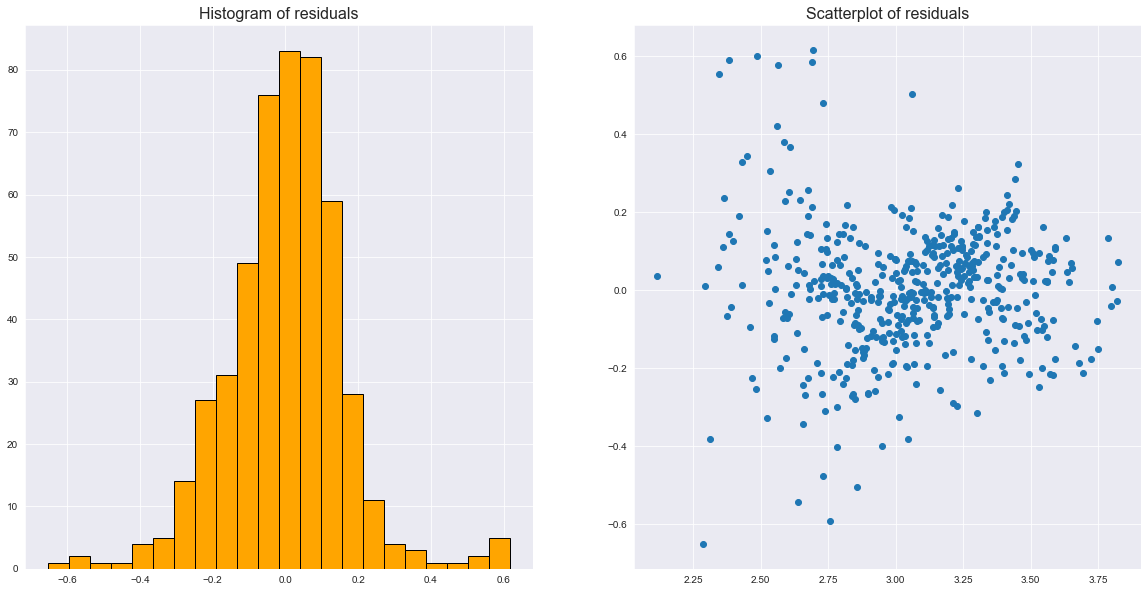

In [119]:
residuals = pipe.predict(X) - y
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
fig, axs = plt.subplots(1, 2, figsize = (20, 10))
axs[0].hist(residuals, bins = round(np.sqrt(X.shape[0])), color = 'orange', edgecolor = 'k')
axs[0].set_title('Histogram of residuals')
axs[1].scatter([pipe.predict(X)[i] for i in np.argsort(pipe.predict(X))], 
               [residuals.values[i] for i in np.argsort(pipe.predict(X))])
axs[1].set_title('Scatterplot of residuals')

We see that the residuals seem to be somewhat normally distributed (although a proper inspection would involve rigorous normality tests), but the scatterplot of residuals by predicted value doesn't seem to be that random - the variance of estimates at lower predictions seems to be higher than those with higher predictions, which implies heteroscedasticity in our dataset. Thus the assumption that the residuals are independent and identically distributed with the same variance $\sigma^2$, is disturbed. This implies that by using a non-robust covariance matrix will lead us to misleading t-tests and confidence intervals.

Moreover, we saw that some of the regressors have shown significant correlation. This might affect our [analysis](https://www.sciencedirect.com/topics/mathematics/multicollinearity-problem) in a way that will further mess up our results. We can check for the collinearity impact thorugh a metric called a Variance Inflation Factor, or VIF:

In [121]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif.sort_values(by = ['VIF'], ascending = False))

    feature         VIF
7       TAX  847.619850
8   PTRATIO  695.135241
3       NOX  156.533838
4        RM  155.425522
5       AGE  118.200312
10    LSTAT   85.849612
9         B   74.329954
6       DIS   67.159548
11      RAD   39.473719
2     INDUS   13.331207
0      CRIM    9.503609
1        ZN    3.012982


A general rule of thumb tells us that a VIF of 10 is already considered very high, meaning that the given variable is highly correlated with other variables. Since our correlation matrix showed strong correlations among several variables, there's no surprise that practically all of our variables have dangerously high VIF. This fact, coupled by the apparent heteroscedasticity in our data, are major warning signs why we shouldn't trust the classical linear regression results. 

Linear regression with the ordinary least squares minimizer is an extremely well known statistical model used in plethora of instances. However, if we want to describe the relationship between the output variable and our chosen input variables, we need to make sure the regression assumptions are met - otherwise we risk getting skewed and misleading results, just as we saw in our Boston housing dataset. We obviously omitted the summary analysis and other further tools (Cook distances for influential outlier detection, step-wise regressor choice etc.). If we wanted to pursue this, a better choice would be using the *OLS* function in the *stats* module, which is more statistically oriented than scikit's *LinearRegression*.

Since we're more interested in creating an accurate prediction model, we don't have to waste precious time checking these rigorous points; in the end the OLS estimator ist the Best Linear Unbiased Estimator of our coefficients $\mathbf{\hat{\beta}}$ and there's nothing stopping us from trying to use it for our prediction. However, let's look at the L1/L2 regularization methods and some feature engineering to hopefully find a more precise prediction model. 

## Ridge Regression, LASSO and some feature engineering 
Ridge regression and LASSO are regularization techniques that impose a penalty on the coefficients vector $\mathbf{\beta}$, which affects the estimate $\mathbf{\hat{\beta}}$ in various ways. Most importantly, the estimate is no longer biased, but has a lower variance - which might help reduce the overall prediction error. As we're limiting the overall magnitude of predictors, these techniques also have the advantage of avoiding overfitting. 

(Sidenote: Ridge regression and LASSO solve the least squares problem subject to a constraint; $\| \mathbf{\beta} \|_2 \leq \theta$ for RR, $\| \mathbf{\beta} \|_1 \leq \theta$ for LASSO. The difference is therefore in the norm of $\| \mathbf{\beta} \|$, which we're imposing the penalty on. The result is that LASSO tends to estimate the unimportant coefficients as zero, $\beta_i = 0$, while ridge regression is unable to fully ignore the coefficients and just predicts them closer and closer to 0. This means that LASSO is also useful as a selection operator.) 

Overall, it's a good idea to use regularization methods when we're trying to build a prediction model using a lot of input variables and we don't know which of them are useful for predicting our output and which are not. In our dataset, we're dealing with a rather small number of features (12), but we haven't considered higher degrees nor interactions between our features, which might unravel more hidden, not obvious patterns in the data. Let's try to create new features this way, scale them and then build a regularized linear model on them. We're using the streamlined scikit approach, where the transformations and feature engineering are a part of a pipe operator, which applies the functions before fitting the model and also avoids any data leakage by finding the best parameters for our setting via GridSearchCV purely on the training dataset. We're consequently testing our model on a testing dataset which was not used at all during the training and therefore should be a good metric for how our model performs on yet unseen data. 

In [122]:
from sklearn.metrics import mean_squared_error
# Load the needed modules
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Repeat the design matrix and output definition to be sure
X = boston.drop(columns = ['MEDV'])
y = boston['MEDV']

# Split it like you mean it 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

# Define the parameter grid for the ridge penalty 
param_grid = {'classifier__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'poly__degree' : [1, 2, 3]}

# Create our pipeline
pipe = Pipeline([
    ('preprocessor', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('classifier', Ridge())
])

# Do the grid search cross-validation 
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)

# Look at the best model
print('Best estimator: {}.'.format(grid.best_params_))
print('The mean CV accuracy on the training set is {:.3f}.'.format(grid.best_score_))
print('The R^2 accuracy on the test set is {:.3f}.'.format(grid.score(X_test, y_test)))
print('The MSE on the test set is {:.3f}.'.format(round(mean_squared_error(grid.predict(X_test), y_test), 4)))

Best estimator: {'classifier__alpha': 10, 'poly__degree': 2}.
The mean CV accuracy on the training set is 0.880.
The R^2 accuracy on the test set is 0.846.
The MSE on the test set is 9.122.


We see that our linear model with L2 regularization achieved an $R^2$ of 0.846, which is pretty good. We can look at the first ten regressors our model considered to be the most important at predicting our output variable. 

In [123]:
import re 
# Create a mask for the predictors with the highest coefficients 
mask = np.argsort(np.abs(grid.best_estimator_['classifier'].coef_))[::-1]

# grid.best_estimator_['classifier'].coef_[mask][:10] 
temp = np.array(grid.best_estimator_['poly'].get_feature_names_out())[mask][:10]

# A kind of messy for loop to print the names of our most important predictors
for i in temp: 
    if i.count('x') == 2: 
        z = re.findall(r'\d+', i)
        print('{}:{}'.format(X.columns[int(z[0])], X.columns[int(z[1])]))
    if i.count('x') == 1:
        z = re.findall(r'\d+', i)
        if len(z) == 2: print('{}^2'.format(X.columns[int(z[0])]))
        if len(z) == 1: print(X.columns[int(z[0])])

RM
LSTAT
AGE:B
TAX:PTRATIO
AGE
TAX
RAD^2
DIS^2
INDUS:NOX
NOX:DIS


Let's try the LASSO regression and see if we can come up with a more accurate model:

In [124]:
# Load the needed modules
from sklearn.linear_model import Lasso

# Define the parameter grid for the ridge penalty 
param_grid = {'classifier__alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'poly__degree' : [1, 2]}

# Create our pipeline
pipe = Pipeline([
    ('preprocessor', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('classifier', Lasso(max_iter = 1000000))
])

# Do the grid search cross-validation 
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)

# Look at the best model
print('Best estimator: {}.'.format(grid.best_params_))
print('The mean CV accuracy on the training set is {:.3f}.'.format(grid.best_score_))
print('The R^2 accuracy on the test set is {:.3f}.'.format(grid.score(X_test, y_test)))
print('The MSE on the test set is {:.3f}.'.format(round(mean_squared_error(grid.predict(X_test), y_test), 4)))

Best estimator: {'classifier__alpha': 0.01, 'poly__degree': 2}.
The mean CV accuracy on the training set is 0.879.
The R^2 accuracy on the test set is 0.843.
The MSE on the test set is 9.291.


We see that the $R^2$ is a bit lower, but overall, the quality seems pretty similar. Let's review the LASSO's function as a selection operator and look at how many coefficients were taken into account for our final model: 

In [125]:
(grid.best_estimator_['classifier'].coef_ != 0).sum()

77

It seems that 77 regressors were taken into account, which is kind of a lot - we only ingored 28 of them. Again, let's look at the top 10 regressors that our model thinks are the most important: 

In [126]:
# Create a mask for the predictors with the highest coefficients 
mask = np.argsort(np.abs(grid.best_estimator_['classifier'].coef_))[::-1]

# grid.best_estimator_['classifier'].coef_[mask][:10] 
temp = np.array(grid.best_estimator_['poly'].get_feature_names_out())[mask][:10]

# A kind of messy for loop to print the names of our most important predictors
for i in temp: 
    if i.count('x') == 2: 
        z = re.findall(r'\d+', i)
        print('{}:{}'.format(X.columns[int(z[0])], X.columns[int(z[1])]))
    if i.count('x') == 1:
        z = re.findall(r'\d+', i)
        if len(z) == 2: print('{}^2'.format(X.columns[int(z[0])]))
        if len(z) == 1: print(X.columns[int(z[0])])

RAD^2
RAD:TAX
RM
LSTAT
TAX:PTRATIO
AGE:B
NOX:DIS
INDUS:NOX
AGE
ZN:RAD


As we can see, some of the predictors were the same as in the ridge regression, with a couple of them different. At this point it would be hard to say which regularization approach yielded better results, as the $R^2$'s were very similar.

## Feedforward Neural Network
A neural network is a complex family of machine learning algorithms that may vary greatly in terms of learning paradigms, topology and overall function. The only apparent thing present in all neural networks are so called 'neurons', which are various mathematical functions that receive inputs, transform them and produce an output, which can then be send forward in the network (usually the case with supervised learning) or serve as a some form of cluster representative (usually with unsupervised learning). The whole topic of neural nets is extremely vast and we will therefore forgo talking about their classification and mathematical theory. Let's just settle on the fact that the most well-known and used type of neural nets, the feedforward neural networks (sometimes called *multilayer perceptrons*) can be used for both binary classification, multinomial clasification and regression as well. I'll use some jargon that people with knowledge about NNs will understand; if you haven't studied this family of algorithms yet, it's no problem, just view them as another ML model with parameters and (quite a lot of) hyperparameters that need to be optimized for them to work as intendend.

Let's build a neural network with 2 hidden layers, with 40 and 60 neurons respectively and 1 output neuron with linear activation (as we're trying to solve a regression problem). We're scaling all of our columns beforehand as neural nets work better with inputs squished into a [0, 1] interval. The activation function in our hidden layers is ReLU, the *rectified linear unit*. Our loss function is set as the classic *mean squared error* and the stop criterion for the learning of our neural net is number of epochs, set to 2000. This is both a bad choice for a stopping criterion and a lot of epochs, just to show the danger that comes with neural networks. The serve as something called *universal approximators*, meaning they are capable, with enough learning, to approximate any well-behaved (usually meaning continuous) function $f: \mathbb{R}^n \rightarrow \mathbb{R}^m$. This means that our net should be able to learn a lot of noise in the data, which will mean our training set mean squared error is lower than with LASSO/Ridge regression, but our model should generalize very poorly on the test set. 

In [127]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

In [128]:
# Import necessary modules 
import tensorflow 
from keras.models import Sequential
from keras.layers import Dense

# Define the nerual network model 
model = Sequential()
model.add(Dense(40, input_dim = 13, activation = 'relu'))
model.add(Dense(60, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

# Compile our model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mean_squared_error'])

In [129]:
# fit the keras model on the dataset
model.fit(X_scaled, y_train, epochs = 2000, batch_size = 64, verbose = 0)

# evaluate the keras model on the training set
_, err = model.evaluate(X_scaled, y_train)
print('MSE train: %.2f' % (err))

13/13 [==============================] - 0s 3ms/step - loss: 3.5708 - mean_squared_error: 3.5708
MSE train: 3.57


As expected, our neural net regressor works a lot better on the training set, having MSE around 4 (compared to Ridge/LASSO which had MSE slightly over 9). This should indicate that our model is overfitting, since on a dataset this simple, we shouldn't be seeing such a great improvement over other algorithms. Let's check if this is true:

In [130]:
# evaluate the keras model on the test set, 85% data used 
_, err = model.evaluate(scaler.transform(X_test), y_test)
print('MSE test: %.2f' % (err))

3/3 [==============================] - 0s 5ms/step - loss: 6.3257 - mean_squared_error: 6.3257
MSE test: 6.33


As expected, our model is clearly overfitting (MSE visibly smaller in the training set than in the test set), our model still showed better results on the test set to the other two approaches. Let's look at some ways of making the neural net more robust and prevent overfitting. Hopefully this will also imporve the performance of our model in the process. 

### Early stopping and validation set addition
Instead of choosing a fixed number of epochs during which our model will learn, and eventually, overlearn the patterns in our training set, let's choose a more dynamic criterion - in this case, we will stop the learning as soon as our model will stop seeing improvement on the validation set. The validation set alone is another needed addition to our model learning, since right now we're only looking at the performance improvement on the training set, which is heavily biased since this is the exact dataset our neural network is learning on. This way, there is always going to be an accuracy improvement epoch-to-epoch, but the weight adjustment doesn't have to generalize well. Validation accuracy is therefore a better indicator of how the model generalizes to previously unseen data. 

In [131]:
from keras.callbacks import EarlyStopping

# Split the data again, this time create a validation set as well
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 7)

# Avoid data leakage
scaler = MinMaxScaler().fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define a nerual network model 
model = Sequential()
model.add(Dense(150, input_dim = 13, activation = 'relu'))
model.add(Dense(200, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

# Create the stopping criterion
callback = EarlyStopping(monitor = 'val_loss', patience = 40, restore_best_weights = True, verbose = 1)

# Compile our model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mean_squared_error'])

# Fit the model 
model.fit(X_tr_scaled, y_train, epochs = 1500, batch_size = 32, callbacks = [callback], 
          validation_data = (X_val_scaled, y_val), verbose = 0)

Restoring model weights from the end of the best epoch.
Epoch 00304: early stopping


In [132]:
_, err = model.evaluate(scaler.transform(X_test), y_test)
print('MSE test: %.2f' % (err))

3/3 [==============================] - 0s 4ms/step - loss: 8.4901 - mean_squared_error: 8.4901
MSE test: 8.49


As we can see, our learning stopped at the 304th epoch. The *patience* parameter was set to 40, meaning that we haven't registered an improvement in validation accuracy in 40 consecutive epochs. Our final performance was slightly better to the LASSO model, but to be fair - our neural network only used about 68% of the data for learning, since we used 20% of the training data for validation. This means that the model achieved better results with less to work with (and worse results than the previous neural net, which used as much of the data as Ridge/LASSO).

### Dropout layers 
Dropout layers are an effective tool that prevent overfitting by randomly dropping some connections in the neural network (i.e. setting their weight vectors to 0). This has a [regularization effect](https://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) on our model and luckily it is very simple to implement in our keras framework:

In [133]:
from keras.layers import Dropout

# Define a nerual network model 
model = Sequential()
model.add(Dense(150, input_dim = 13, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))

# Create the stopping criterion
callback = EarlyStopping(monitor = 'val_loss', patience = 40, restore_best_weights = True, verbose = 1)

# Compile our model
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mean_squared_error'])

# Fit the model 
model.fit(X_tr_scaled, y_train, epochs = 1500, batch_size = 64, callbacks = [callback], 
          validation_data = (X_val_scaled, y_val), verbose = 0)

Restoring model weights from the end of the best epoch.
Epoch 00493: early stopping


In [134]:
_, err = model.evaluate(X_tr_scaled, y_train)
print('MSE train: %.2f' % (err))
_, err = model.evaluate(scaler.transform(X_test), y_test)
print('MSE test: %.2f' % (err))

11/11 [==============================] - 0s 4ms/step - loss: 4.4336 - mean_squared_error: 4.4336
MSE train: 4.43
3/3 [==============================] - 0s 5ms/step - loss: 8.8377 - mean_squared_error: 8.8377
MSE test: 8.84


Again, we got pretty similar results to our previous models, while our new used techniques should alleviate the problem of overfitting a bit (which still, however, persists). We used some pretty complex neural nets and therefore tried to get it to overfit on our small dataset. 

This was a showcase of how to implement a feedforward neural network model on a dataset. An algorithm for a dataset this size (~ 500 rows) is probably overkill, but as we have seen, we may achieve some predictive edge compared to the simpler models. The problem of neural nets is, that they serve as a kind of *black box* approach, meaning that even though we can successfully train and implement a predictive machine learning model, we don't really know what the inner workings of our neural net are, comapared to Ridge/LASSO where we just could look at the predictors our models deem as the most important. 

If we wanted to use these models in practice, namely for prediction, it would be necessary to test them further to see if they still generalize well to new, yet unseen data. If there is a change in the realtionship of new observed outputs and their inputs, we will see this as a continuous drop in performance of our models, as they were trained on a dataset with different patterns and need to be updated.  